### Performs the continuous vector embedding of MassBank & GNPS molecules (trained on PubChem data)

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pickle
import glob
import pprint
import requests

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn import linear_model
from sklearn.preprocessing import normalize

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

import pubchempy as pcp
from keras.models import Sequential, Model, load_model

/Users/joewandy/anaconda/envs/neural_net/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
import sys

sys.path.append('/Users/joewandy/git/keras-molecules')
from molecules.model import MoleculeVAE, SimpleMoleculeVAE
from molecules.utils import one_hot_array, one_hot_index, from_one_hot_array, \
    decode_smiles_from_indexes, load_dataset
    
sys.path.append('/Users/joewandy/git/lda/code/')
from classyfire_interface import get_taxa_path_and_substituents

from embedding import to_one_hot_array, get_input_arr, autoencode, encode
from embedding import visualize_latent_rep, get_classifyre, get_scatter_colours
from embedding import make_plot

#### Load MassBank & GNPS data

In [4]:
def fetch_or_load(ms2lda_url, data_file):

    if len(glob.glob(data_file)) > 0:
        print "Loading %s from file" % data_file
        with open(data_file,'r') as f:
            data = pickle.load(f)
    else:
        print "Fetching %s from server" % data_file
        r = requests.get(ms2lda_url)
        data = r.json()
        with open(data_file,'w') as f:
            pickle.dump(data,f)

    return data

In [5]:
def load_data(data):

    experiment_ids = {'gnps':191, 'massbank':190}
    doc_data_file = data + '_docs_data.dict'
    doc_metadata_file = data + '_docs_metadata.dict'
    
    ms2lda_url = 'http://ms2lda.org/basicviz/get_all_parents_metadata/{}/'.format(experiment_ids[data])    
    metadata = fetch_or_load(ms2lda_url, doc_metadata_file)
    
    ms2lda_url = 'http://ms2lda.org/basicviz/get_all_doc_data/{}/'.format(experiment_ids[data])    
    doc_data = fetch_or_load(ms2lda_url, doc_data_file)
    
    return metadata, doc_data

In [6]:
data = 'massbank'
massbank_metadata, massbank_doc_data = load_data(data)

Loading massbank_docs_metadata.dict from file
Loading massbank_docs_data.dict from file


In [7]:
data = 'gnps'
gnps_metadata, gnps_doc_data = load_data(data)

Loading gnps_docs_metadata.dict from file
Loading gnps_docs_data.dict from file


In [8]:
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(massbank_doc_data[0])
pp.pprint(massbank_metadata[0])

[u'eawag_0313.ms',
 [[u'fragment_212.0675', 1.0],
  [u'loss_61.0325', 0.0],
  [u'loss_114.0525', 3.0],
  [u'loss_43.0425', 582.0],
  [u'loss_59.0725', 7.0],
  [u'loss_44.0475', 0.0],
  [u'fragment_172.0375', 7.0],
  [u'loss_45.0575', 16.0],
  [u'loss_140.0575', 0.0],
  [u'loss_69.0575', 2.0],
  [u'loss_85.0775', 0.0],
  [u'fragment_91.0525', 0.0],
  [u'fragment_121.0425', 2.0],
  [u'fragment_93.0575', 0.0],
  [u'loss_58.0625', 0.0],
  [u'fragment_140.0325', 1.0],
  [u'fragment_173.0325', 1.0],
  [u'fragment_171.0425', 0.0],
  [u'fragment_104.0475', 2.0],
  [u'loss_31.0425', 15.0],
  [u'loss_104.0725', 10.0],
  [u'loss_29.0275', 0.0],
  [u'loss_44.0525', 0.0],
  [u'loss_63.0475', 22.0],
  [u'loss_175.0625', 1.0],
  [u'fragment_201.0625', 2.0],
  [u'loss_91.0775', 1.0],
  [u'loss_139.0475', 0.0],
  [u'fragment_151.0375', 2.0],
  [u'fragment_200.0675', 15.0],
  [u'fragment_168.0625', 22.0],
  [u'loss_83.0575', 0.0],
  [u'fragment_92.0625', 0.0],
  [u'fragment_211.1025', 12.0],
  [u'fragme

#### Load VAE model

In [9]:
data_file = '/Users/joewandy/git/keras-molecules/preprocessed/pubchem_500k.h5'
model_file = '/Users/joewandy/Dropbox/Analysis/autoencoder/models/pubchem_500k.h5'
latent_dim = 100

In [10]:
train_data, test_data, charset = load_dataset(data_file)
print charset

[' ' '(' '.' '0' '2' '4' '6' '8' 'B' 'D' 'F' 'H' 'L' 'N' 'P' 'R' 'T' 'V'
 'Z' 'b' 'd' 'f' 'h' 'l' 'n' 'p' 'r' 't' '#' '%' ')' '+' '-' '1' '3' '5'
 '7' '9' '=' 'A' 'C' 'E' 'G' 'I' 'K' 'M' 'O' 'S' 'U' 'W' 'Y' '[' ']' 'a'
 'c' 'e' 'g' 'i' 'm' 'o' 's' 'u' 'y']


In [11]:
model = SimpleMoleculeVAE()
model.load(charset, model_file, latent_rep_size=latent_dim)

#### MassBank Embedding

In [12]:
def visualize_latent_rep(data_train, data, model, latent_dim, colours=None, hide=False):
    
    if colours and hide: # exclude those with no classifyre type from the plot
        assert len(data) == len(colours)
        new_data = []
        new_colours = []
        for i in range(len(data)):
            if colours[i] != 0: # 0 is for None
                new_data.append(data[i])
                new_colours.append(colours[i])
        data = np.array(new_data)
        colours = np.array(new_colours) - 1

    # sample some random training points
    num_samples = 10000
    idx = np.random.randint(data_train.shape[0], size=num_samples)
    train_latent = model.encoder.predict(data_train[idx])
    data_latent = model.encoder.predict(data)        
    
    # use all the training data
    # x_latent = model.encoder.predict(data_train) 
    # num_samples = x_latent.shape[0]    

    X = np.concatenate((train_latent, data_latent), axis=0)
    
    pca = PCA(n_components = 20)
    transformed = pca.fit_transform(X)
    evr = pca.explained_variance_ratio_
    print evr
    print 'Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1])
    print 'Explained variations -- all components: %.2f' % np.sum(evr)

#     tsne = TSNE(n_components = 2)
#     transformed = tsne.fit_transform(X)

    plt.figure(figsize=(12, 12))
    plt.scatter(transformed[0:num_samples, 0], transformed[0:num_samples, 1], marker='.', alpha=0.1, color='gray')
    
    if colours is not None:
        cmap = plt.cm.jet
        plt.scatter(transformed[num_samples:, 0], transformed[num_samples:, 1], marker='.', c=colours, 
                    cmap=cmap, alpha=0.5)
        plt.colorbar()
    else:
        plt.scatter(transformed[num_samples:, 0], transformed[num_samples:, 1], marker='.', alpha=0.5)
        
    plt.title('Latent Dim %d' % latent_dim)

In [13]:
def get_classifyre(inchikeys, out_file=None):

    if len(glob.glob(out_file)) > 0:
        print "Loading %s from file" % out_file
        with open(out_file,'r') as f:
            data = pickle.load(f)
            taxa = data[0]
            subs = data[1]
    else:

        print "Fetching %s from server" % out_file
        taxa = {}
        subs = {}
        for i in range(len(inchikeys)):
            if i % 100 == 0:
                print '%d/%d' % (i, len(inchikeys))
            inchikey = inchikeys[i]
            taxa_path, substituents = get_taxa_path_and_substituents(inchikey)
            taxa[inchikey] = taxa_path
            subs[inchikey] = substituents

        data = (taxa, subs,)
        with open(out_file,'w') as f:
            pickle.dump(data, f)
    
    return taxa, subs

In [14]:
def get_scatter_colours(inchikeys, taxa_path):
    
    superclasses = []
    for inchikey in inchikeys:
        if inchikey in taxa_path:
            t = taxa_path[inchikey]
            if len(t) > 0:
                superclass = t[1] # kingdom, superclass, class, subclass ...
            else:
                superclass = None
        else:
            superclass = None
        superclasses.append(superclass)
        
    unique_superclasses = sorted(list(set(superclasses)))
    superclass_idx = {}
    for i, x in enumerate(unique_superclasses):
        superclass_idx[x] = i
        print i, x

    superclasses_idx = [superclass_idx[sp] for sp in superclasses]
    return superclasses_idx

In [15]:
massbank_smiles = [m['smiles'] for m in massbank_metadata]
massbank_inchikeys = [m['InChIKey'] for m in massbank_metadata]

In [16]:
massbank_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in massbank_smiles]

In [17]:
input_array = get_input_arr(massbank_smiles, charset)

In [18]:
autoencode(model, charset, input_array, N=10)

i> "FC(F)(F)c1cccc(N2CCNCC2)c1"
o> "CC(F)(F)c1cccc(N2CCCCC2)c1"

i> "COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2OC2OC(CO)C(O)C(O)C2O)ccc1O"
o> "COc1cc(-c2nc3c((C)cc(O)ccc(==)c(CCCCCCCCCC(O))=C)C)C2)cc1"

i> "O=C(C=Cc1ccc(O)c(O)c1)c1ccc(OC2OC(CO)C(O)C(O)C2O)c(O)c1O"
o> "O=CC(=Cc1ccc(O)c(1)c1-c1ccc(OCCCCCCCCC(O))=F)F)CCCC))11"

i> "CC1CC2C(C(O)CC3(C)C2CCC3(O)C(=O)CO)C2(C)C=CC(=O)C=C12"
o> "CC1CCCCCC(O)C(CC)CCCCCCC(C)C(=O)CCCCCCCCCCCC(=O)CCC1"

i> "COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(N=C(C)O)CC2"
o> "COc1cc2c(c11c)cc1C((c1ccc(OC)c2)ccc1=)11CC(C)C)CC2"

i> "COc1cc(-c2cc(=O)c3c(O)c(OC)c(OC4OC(COC5OC(C)C(O)C(O)C5O)C(O)C(O)C4O)cc3o2)ccc1O"
o> "COc1cc(-c2cc(OO)c4c(C)c(())c(C)CCCCCCCCCCCCCCC)CCCCCCCCCCCCC)ccccccccccccCC)cc1"

i> "COCC(=O)N(c1c(C)cccc1C)C(C)C(=O)O"
o> "CCCC(=O)O)c1c(c)cccc11)C1C)C(=O)O"

i> "CCOc1ccc2ccccc2c1C(O)=NC1C(=O)N2C1SC(C)(C)C2C(=O)O"
o> "CCOc1ccc2ccccc2c1C(O)=NC(C(=O)N1CCCC(C)CC)CCC(=O)O2"

i> "O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12"
o> "CCn1c(CON(-c2ccc(O)cc2)n2ccc(C)ccc2)c12

In [19]:
massbank_latent = encode(model, input_array)

In [20]:
taxa_path, substituents = get_classifyre(massbank_inchikeys, out_file='massbank_classifyre.dict')
massbank_superclasses_idx = get_scatter_colours(massbank_inchikeys, taxa_path)

Loading massbank_classifyre.dict from file
0 None
1 Alkaloids and derivatives
2 Benzenoids
3 Hydrocarbon derivatives
4 Lignans, neolignans and related compounds
5 Lipids and lipid-like molecules
6 Nucleosides, nucleotides, and analogues
7 Organic Polymers
8 Organic acids and derivatives
9 Organic nitrogen compounds
10 Organic oxygen compounds
11 Organohalogen compounds
12 Organoheterocyclic compounds
13 Organophosphorus compounds
14 Organosulfur compounds
15 Phenylpropanoids and polyketides


[ 0.31040394  0.15728373  0.10543478  0.06865648  0.06364304  0.03696944
  0.02978059  0.02545402  0.02157544  0.01719424  0.01693434  0.01446607
  0.01338595  0.01179592  0.01033566  0.0094118   0.00765713  0.00752742
  0.00710075  0.006532  ]
Explained variations -- first two PCs: 0.47
Explained variations -- all components: 0.94


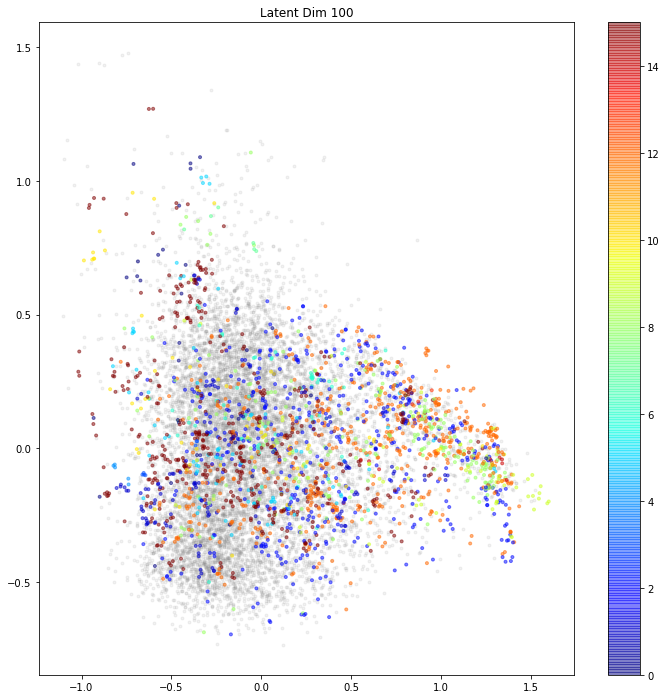

In [21]:
visualize_latent_rep(train_data, input_array, model, 
                                     latent_dim, colours=massbank_superclasses_idx)

In [22]:
def visualize_data_with_motifname(motif_name, doc_data, input_array, data_train, threshold = 0.0, annotation = ""):

    pos = []
    n = len(doc_data)
    for i in range(n):
        for (motif, prob, overlap) in doc_data[i][2]:
            if motif == motif_name and prob > threshold:
                pos.append(i)
    print pos
    
    # sample some random training points
    num_samples = 5000
    idx = np.random.randint(data_train.shape[0], size=num_samples)
    train_latent = model.encoder.predict(data_train[idx])
    data_latent = model.encoder.predict(input_array)        
    
    # use all the training data
    # x_latent = model.encoder.predict(data_train) 
    # num_samples = x_latent.shape[0]    

    X = np.concatenate((train_latent, data_latent), axis=0)
    
    pca = PCA(n_components=20)
    transformed = pca.fit_transform(X)
    evr = pca.explained_variance_ratio_
    print evr
    print 'Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1])
    print 'Explained variations -- all components: %.2f' % np.sum(evr)

    pos = num_samples + np.array(pos)
    plt.figure(figsize=(12, 12))
    plt.scatter(transformed[0:num_samples, 0], transformed[0:num_samples, 1], marker='.', alpha=0.1, color='gray')
    plt.scatter(transformed[num_samples:, 0], transformed[num_samples:, 1], marker='.', alpha=0.5)    
    plt.scatter(transformed[pos, 0], transformed[pos, 1], marker='+', s=150)            
    plt.title('PCA - Latent Dim {} with {}: {}'.format(latent_dim, motif_name, annotation))
    plt.show()

In [23]:
test_dict = {
#     "motif_14": 'Combination of small losses (i.e. NH3 and CH2O2)',
#     "motif_10": 'Loss of C3H6 - indicative for the presence of an isopropyl group',
#     "motif_32": 'Fragments indicative for ferulic acid based substructure (MzCloud)',
#     "motif_28": 'Fragment ions indicative for C6H12NO substructure (in beer related to N-acetylputrescine - MzCloud)',
#     "motif_24": 'Fragments indicative of a glycosylation - i.e. indicative for a sugar conjugation (in beer often related to glucose)',
#     "motif_18": 'CO loss - indicative for presence of ketone/aldehyde/lactone group (C=O)',
#     "motif_34": 'Double water loss i.e. 2*H20  Generic feature for metabolites containing several free OH groups attached to a aliphatic chain like sugars.',
#     "motif_13": 'Alkyl aromatic substructure   indicative for aromatic ring with 2-carbon alkyl chain attached i.e. phenylethene fragment from ethylbenzene as a result of the fragmentation process.',
#     "motif_24": 'Fragments indicative of a glycosylation - i.e. indicative for a sugar conjugation (in beer often related to glucose)',
#     "motif_41": 'Loss indicative of [hexose-H20]'
    "motif_21": "Adenine (1)",
    "motif_39": "Adenine (2)",    
    "motif_16": "Quercetin",
    "motif_42": "Kaempferol"
}

[14, 20, 29, 151, 218, 225, 243, 245, 275, 347, 359, 408, 485, 511, 656, 681, 748, 749, 784, 792, 1057, 1207, 1448, 1510, 1554, 1613]
[ 0.35482495  0.14676538  0.09907313  0.06342847  0.06048446  0.03310474
  0.02929842  0.02320898  0.01963586  0.01698668  0.01599585  0.01362755
  0.01281907  0.0104287   0.00939427  0.00911982  0.0073772   0.00705299
  0.00651984  0.0060289 ]
Explained variations -- first two PCs: 0.50
Explained variations -- all components: 0.95


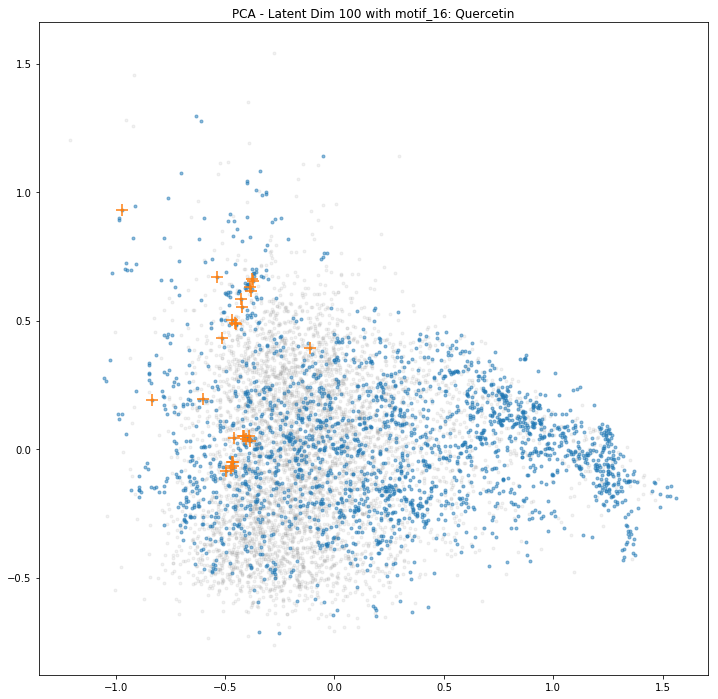

[36, 41, 81, 151, 194, 201, 253, 294, 350, 359, 450, 475, 602, 610, 781, 852, 875, 908, 1302, 1370, 1382, 1432, 1511, 1630, 1757, 1788, 1858]
[ 0.35375907  0.14832594  0.09706918  0.064823    0.06084254  0.03290008
  0.02954554  0.02397472  0.02055814  0.01644184  0.01581579  0.01372238
  0.01236859  0.01082361  0.00943813  0.00869013  0.00731788  0.00698068
  0.00646475  0.00601147]
Explained variations -- first two PCs: 0.50
Explained variations -- all components: 0.95


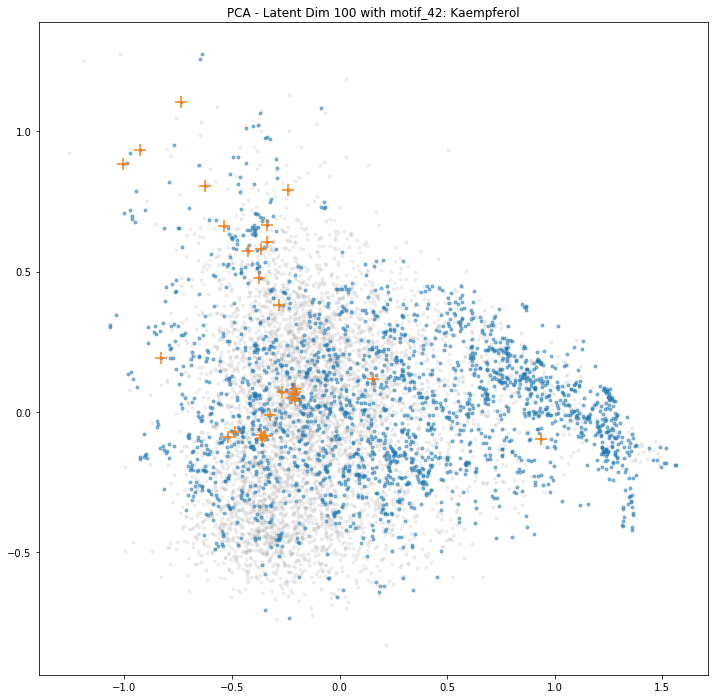

[179, 219, 255, 444, 753, 777, 897, 1141, 1214, 1215, 1322, 1332, 1783, 1862, 1950, 2036]
[ 0.34521924  0.14916936  0.10484811  0.06408573  0.06038067  0.03333866
  0.02839761  0.02366696  0.01974477  0.01667941  0.0158571   0.01439445
  0.01247574  0.01098885  0.00976765  0.00889968  0.00718426  0.00711053
  0.00658405  0.00607419]
Explained variations -- first two PCs: 0.49
Explained variations -- all components: 0.94


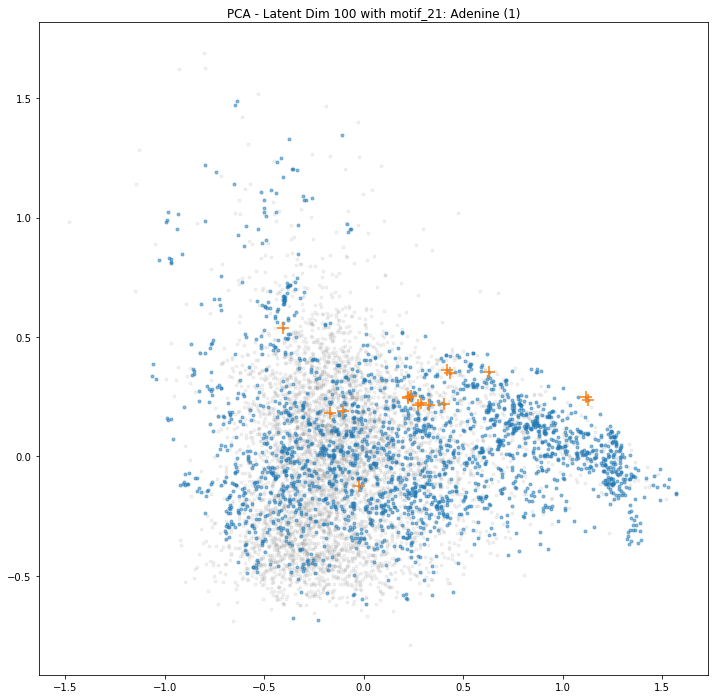

[62, 115, 160, 255, 444, 728, 796, 1222, 1245, 1322, 1668, 1783, 1862, 2036]
[ 0.36024201  0.14302968  0.09960395  0.06201886  0.06059947  0.03299397
  0.02918579  0.02308047  0.02030634  0.01672282  0.0161818   0.01364751
  0.0124084   0.01053221  0.00958697  0.00897991  0.0073379   0.0069283
  0.00658576  0.00595624]
Explained variations -- first two PCs: 0.50
Explained variations -- all components: 0.95


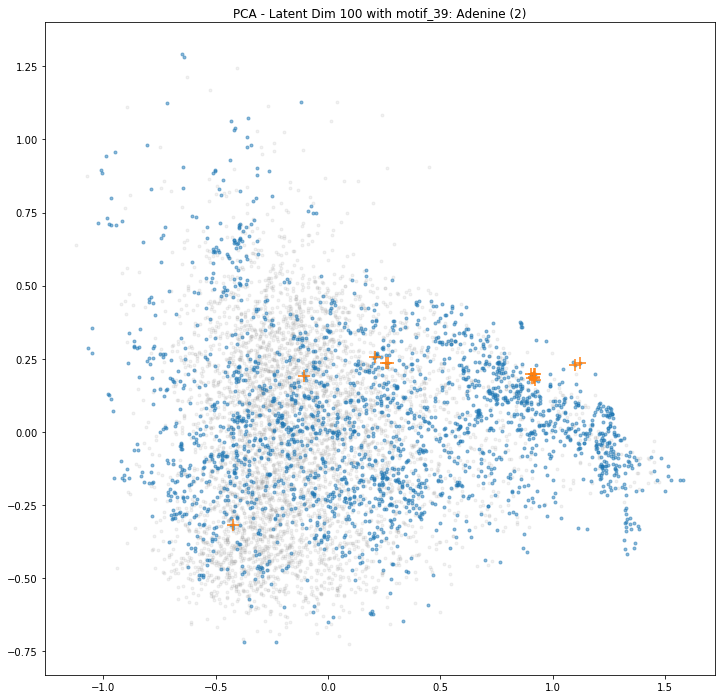

In [24]:
for k,v in test_dict.items():
    visualize_data_with_motifname(k, massbank_doc_data, input_array, train_data, threshold = 0.1, annotation = v)

#### GNPS Embedding

In [25]:
gnps_smiles = [m['smiles'] for m in gnps_metadata]
gnps_inchikeys = [m['InChIKey'] for m in gnps_metadata]

In [26]:
gnps_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in gnps_smiles]

In [27]:
input_array = get_input_arr(gnps_smiles, charset)

In [28]:
autoencode(model, charset, input_array, N=10)

i> "CC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C"
o> "CC(=O)O11CCCCCCCCCC4C(=O)C4CCCCCCCCCC1CC"

i> "C#CC1(O)CCC2C3CCC4=CC(=O)CCC4C3CCC21CC"
o> "CCCCC(C)CCCCCCCCCCC4C(=O)C4CCCCCC3C11C"

i> "CC1C=CC=CC=CC=CC=CC=CC=CC(OC2OC(C)C(O)C(N)C2O)CC2OC(O)(CC(O)CC(O)C(O)CCC(O)CC(O)CC(=O)OC(C)C(C)C1O)CC(O)C2C(=O)O"
o> "CC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(O))(()CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC"

i> "C=C1C(=O)OC2C=C(C)C3=CC(=O)C(C)(CC(OC(=O)C(C)=CC)C12)O3"
o> "C=C1C(=O)O1CCCC(C)(C)CC(=O)C(C)(C)C)C(=O)C(C)(C)CCCCC1"

i> "CC1C=CC=CC=CC=CC=CC=CC=CC(OC2OC(C)C(O)C(N)C2O)CC2OC(O)(CC(O)CC(O)C(O)CCC(O)CC(O)CC(=O)OC(C)C(C)C1O)CC(O)C2C(=O)O"
o> "CC(CCC(CCCCCCCCCCCCCCCCCCCCCCCCCCCC(O)C(C)C)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC"

i> "COc1cc(C=CC(O)=NC(=O)c2ccccc2O)ccc1OC(C)=O"
o> "COc1cc(C=CC(O)=NC(=O)c2ccccc2C))cc1OC(C)CO"

i> "CSCCC(NS(=O)(=O)c1ccc(C)cc1)C(=O)N1CCC(C(O)=NC(C)C(=O)O)CC1"
o> "CCCCC((S(=O)(=O)c1ccc(F)cc1)C(=O)N1CCCCC(O)=NCCCCCCCC(CC)C"

In [29]:
gnps_latent = encode(model, input_array)

In [30]:
taxa_path, substituents = get_classifyre(gnps_inchikeys, out_file='gnps_classifyre.dict')
gnps_superclasses_idx = get_scatter_colours(gnps_inchikeys, taxa_path)

Loading gnps_classifyre.dict from file
0 None
1 Alkaloids and derivatives
2 Benzenoids
3 Hydrocarbon derivatives
4 Lignans, neolignans and related compounds
5 Lipids and lipid-like molecules
6 Nucleosides, nucleotides, and analogues
7 Organic 1,3-dipolar compounds
8 Organic acids and derivatives
9 Organic nitrogen compounds
10 Organic oxygen compounds
11 Organohalogen compounds
12 Organoheterocyclic compounds
13 Organophosphorus compounds
14 Organosulfur compounds
15 Phenylpropanoids and polyketides


[ 0.26705884  0.21075579  0.11894204  0.06362903  0.05664122  0.03884582
  0.03108321  0.02286165  0.02035187  0.01768311  0.01478937  0.01310114
  0.01230654  0.01088255  0.00977084  0.00903888  0.00709528  0.00681806
  0.0062685   0.00574581]
Explained variations -- first two PCs: 0.48
Explained variations -- all components: 0.94


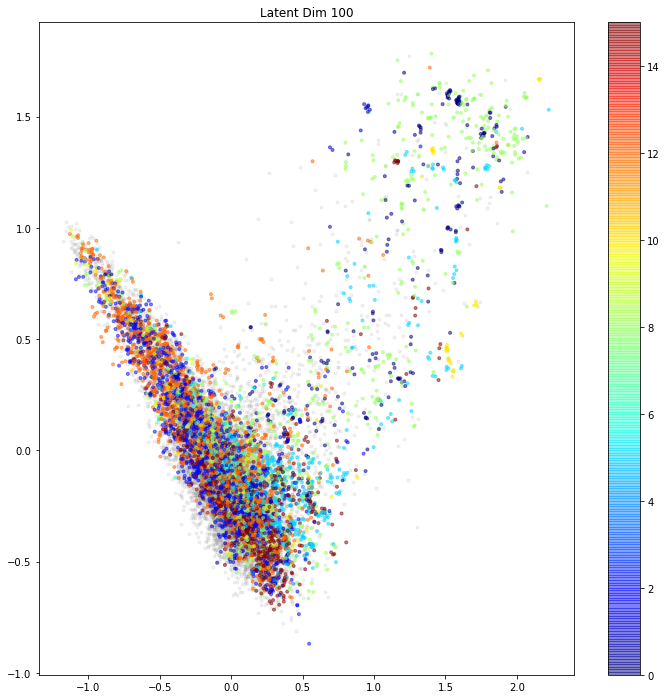

In [31]:
visualize_latent_rep(train_data, input_array, model, latent_dim, 
                             colours=gnps_superclasses_idx)

### Make predictions

In [32]:
def predict_parent_masses(metadata, latent_rep):
    
    parentmass_idx = [float(metadata[i]['parentmass']) for i in range(len(metadata))]    
    X_train, X_test, y_train, y_test = train_test_split(latent_rep, 
                                                        parentmass_idx, 
                                                        test_size=0.33, 
                                                        random_state=42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print mean_squared_error(y_test, lr.predict(X_test))
    
    plt.scatter(y_test, lr.predict(X_test), s=1)
    plt.xlabel('Actual Parent Mass')
    plt.ylabel('Predicted Parent Mass')

3015.18690308


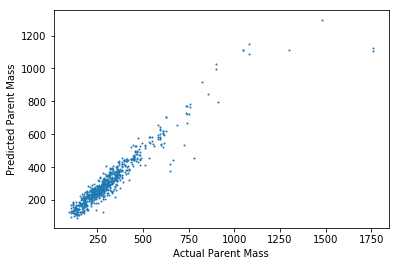

In [33]:
predict_parent_masses(massbank_metadata, massbank_latent)

In [34]:
def get_nominals(doc_data):

    max_mass = 1000
    all_nominals = []
    for n in range(len(doc_data)):
        doc_masses = []
        doc_intensities = []
        for (frag, intensity) in doc_data[n][1]:
            mass = float(frag.split("_")[1])
            doc_masses.append(mass)
            doc_intensities.append(intensity)

        doc_masses = np.round(np.array(doc_masses)).tolist()
        doc_intensities = np.array(doc_intensities)

        nominal = np.zeros(max_mass)
        for m, i in zip(doc_masses, doc_intensities):
            nominal[int(m)-1] += i
        all_nominals.append(nominal)

    all_nominals = np.array(all_nominals)
    return all_nominals

In [35]:
THRESHOLD = 0.01

def predict_spectra(doc_data, latent_mat, N=5):
    
    nominals = get_nominals(doc_data)
    
    # relative intensities -- divide rows by sum
    # x_norm = nominals/nominals.sum(axis=1)[:,None]

    # relative intensities -- divide rows by max
    # x_norm = nominals/nominals.max(axis=1)[:,None]

    # absolute intensities??
    x_norm = nominals
        
    X_train, X_test, y_train, y_test = train_test_split(latent_mat, 
                                                        x_norm, 
                                                        test_size=0.20, 
                                                        random_state=42)

    reg = linear_model.RidgeCV()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    for i in range(N):
        pred = y_pred[i]
        pred[pred < THRESHOLD] = 0
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.plot(y_test[i])
        ax2.plot(pred)
        ax1.set_title('Observed spectra')
        ax1.set_ylabel('Relative intensities')
        ax1.set_xlabel('Nominal m/z')
        ax2.set_title('Predicted spectra')
        ax2.set_xlabel('Nominal m/z')
        plt.show()

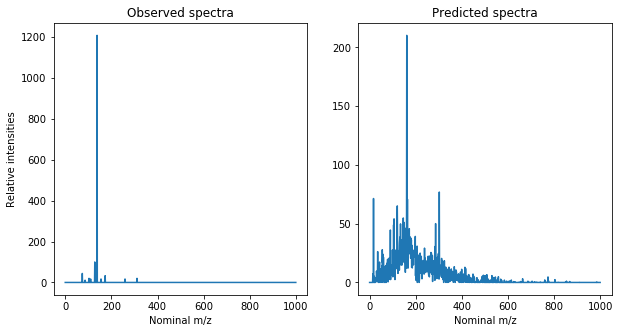

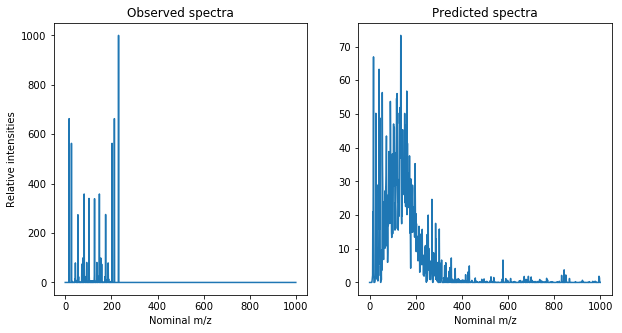

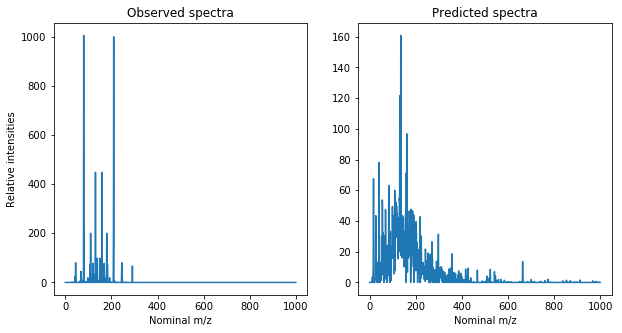

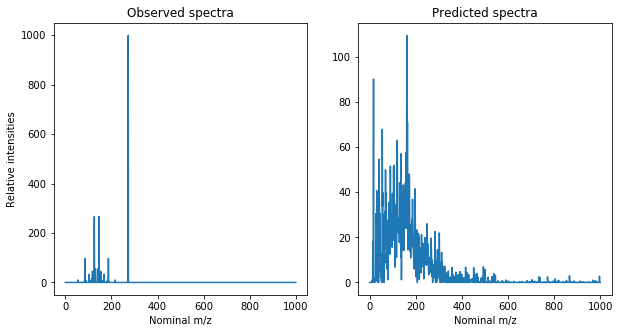

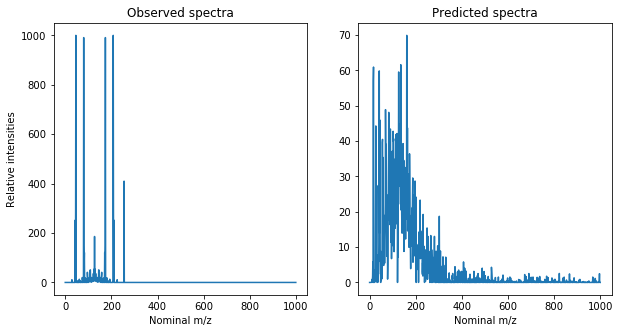

In [36]:
predict_spectra(massbank_doc_data, massbank_latent)

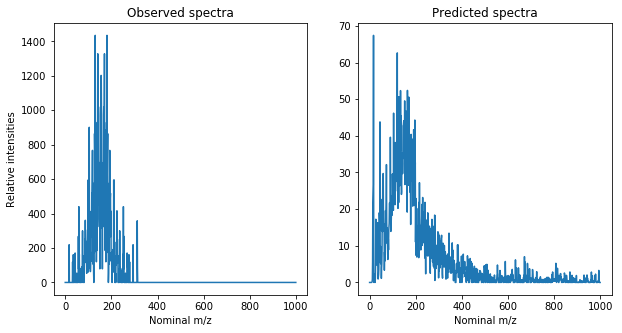

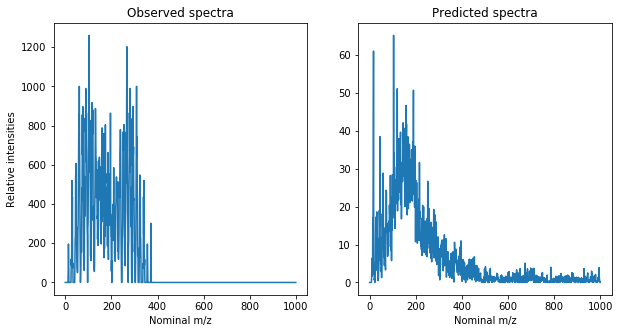

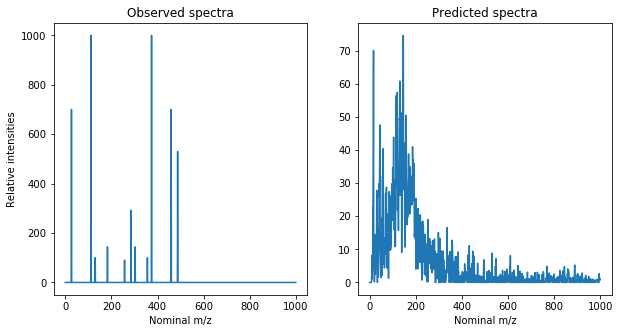

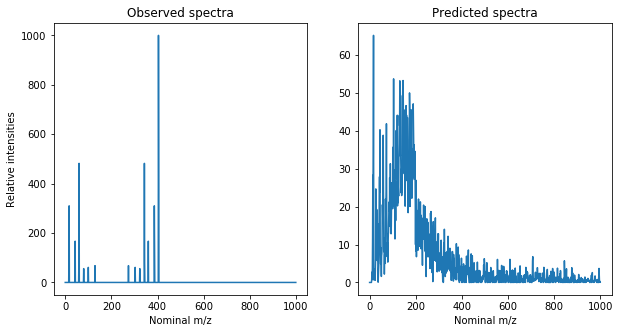

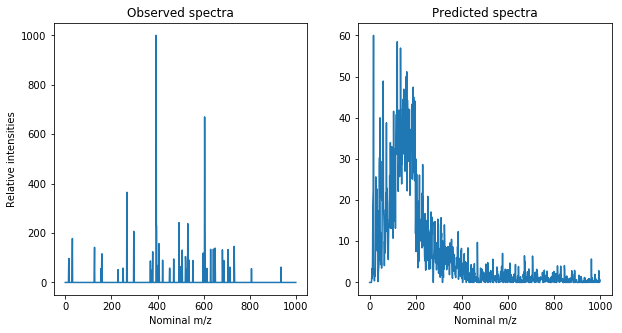

In [37]:
predict_spectra(gnps_doc_data, gnps_latent)

### Inteprolations

Broken ..

In [38]:
def get_molecule(smile_list, metadata_list, idx):
    m = Chem.MolFromSmiles(gnps_smiles[idx])
    return m, smile_list[idx], metadata_list[idx]['compound']

In [39]:
def interpolate(source, dest, steps, charset, model, latent_dim, width):
    
    charset_list = charset.tolist()        
    source_just = source.ljust(width)
    dest_just = dest.ljust(width)
    one_hot_encoded_fn = lambda row: map(lambda x: one_hot_array(x, len(charset_list)),
                                                one_hot_index(row, charset_list))
    source_encoded = np.array(map(one_hot_encoded_fn, source_just))
    source_x_latent = model.encoder.predict(source_encoded.reshape(1, width, len(charset_list)))
    dest_encoded = np.array(map(one_hot_encoded_fn, dest_just))
    dest_x_latent = model.encoder.predict(dest_encoded.reshape(1, width, len(charset_list)))

    step = (dest_x_latent - source_x_latent)/float(steps)
    results = []
    for i in range(steps):
        item = source_x_latent + (step  * i)
        sampled = model.decoder.predict(item.reshape(1, latent_dim)).argmax(axis=2)[0]
        sampled = decode_smiles_from_indexes(sampled, charset)
        results.append( (i, item, sampled) )

    return results

In [40]:
for i, met in enumerate(gnps_metadata):
    print i, met['compound']

0 Progesterone M+H
1 Levonorgestrel (Levonelle) [M+H]
2 Amphotericin B M+H
3 Lychnopholide M+H
4 Amphotericin B M+H
5 MLS001146630-01![4-[(E)-3-[(2-hydroxybenzoyl)amino]-3-oxoprop-1-enyl]-2-methoxyphenyl] acetate M+H
6 MLS001142798-01!(2S)-2-[[1-[(2S)-2-[(4-methylphenyl)sulfonylamino]-4-methylsulfanylbutanoyl]piperidine-4-carbonyl]amino]propanoic acid M+H
7 ribose M+Na
8 AdefovirDipivoxil M+H
9 Glicirrizic acid M+H
10 1009_DCOIT M+H
11 Destruxin-E_diol;_SB-285968_34837_dereplictor_pv_2.83311e-12 M+H
12 "MLS001240196-01!2-(2,3-Dimethyl-phenylamino)-nicotinic acid" M+H
13 6-hydroxy-7-methyoxyscytophycin E M+Na
14 MLS002153425-01!Trifluperidol hydrochloride2062-77-3 M+H
15 MLS002154212-01!Canrenoic acid potassium salt2181-04-6 M+H
16 0144_Pethoxamid M+H
17 MLS001332601-01!Dehydroisoandrosterone 3-sulfate sodium salt dihydrate1099-87-2 M+H
18 "MLS000876825-01!3-benzyl-4-methyl-1,3-dihydro-1,4-benzodiazepine-2,5-dione" M+H
19 MLS002153877-01!5908-99-6 M+H
20 Desferrichrome M+K
21 Ruxolitini

CC(C)C(O)=Nc1ccc([N+](=O)[O-])c(C(F)(F)F)c1 Flutamide (Eulexin) [M+H]


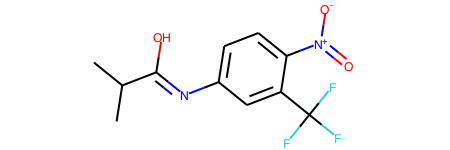

In [41]:
m1, smile1, name1 = get_molecule(gnps_smiles, gnps_metadata, 62)
print smile1, name1
m1

CC(CCC(O)=NCC(=O)O)C1CCC2C3C(O)CC4CC(O)CCC4(C)C3CC(O)C12C Glycocholic acid M+H


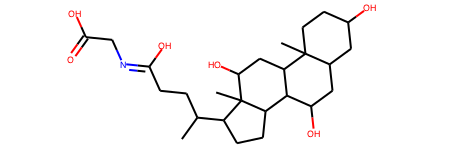

In [42]:
m2, smile2, name2 = get_molecule(gnps_smiles, gnps_metadata, 95)
print smile2, name2
m2

In [43]:
def get_canonical_smile(smile):
    print smile
    smile = Chem.MolToSmiles(Chem.MolFromSmiles(smile))
    return smile

COc1cc(ccc1O)/C=C/C(=O)O


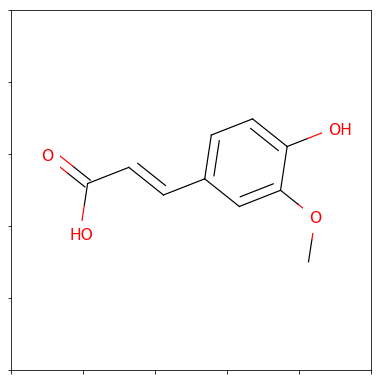

In [44]:
x = 'COc1cc(ccc1O)/C=C/C(=O)O'
smile1 = get_canonical_smile(x)
m = Chem.MolFromSmiles(smile1)
fig = Draw.MolToMPL(m, size=(200, 200))

Oc1ccc(cc1)CCN


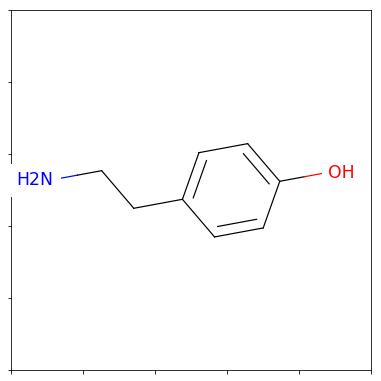

In [45]:
x = 'Oc1ccc(cc1)CCN'
smile2 = get_canonical_smile(x)
m = Chem.MolFromSmiles(smile2)
fig = Draw.MolToMPL(m, size=(200, 200))

In [46]:
results = interpolate(smile1, smile2, 40, charset, model, 100, 120)

In [47]:
for result in results:
    idx = result[0]
    interpolated = result[2]
    try:
        x = get_canonical_smile(interpolated)
        m = Chem.MolFromSmiles(x)
        fig = Draw.MolToMPL(m, size=(200, 200))
    except Exception as msg:
        continue
    break

]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]

RDKit ERROR: [13:44:01] SMILES Parse Error: syntax error for input: ']]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]'
RDKit ERROR: [13:44:01] SMILES Parse Error: syntax error for input: ']]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]'
RDKit ERROR: [13:44:01] SMILES Parse Error: syntax error for input: ']]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]'
RDKit ERROR: [13:44:01] SMILES Parse Error: syntax error for input: ']]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]'
RDKit ERROR: [13:44:01] SMILES Parse Error: syntax error for input: ']]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]'
RDKit ERROR: [13:44:01] SMILES Parse Error: s